<a href="https://colab.research.google.com/github/AlexLeoShin/SeminarGit/blob/main/%D0%9C%D0%BE%D0%B4%D1%83%D0%BB%D1%8C8_%D0%A8%D0%BB%D1%8E%D0%BF%D0%BA%D0%B8%D0%BD%D0%90%D0%9B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Шлюпкин Алексей Леонидович**

# **Блокнот по сверточным сетям**

## Импорт библиотек

In [1]:
import copy
import datetime
import random
import traceback
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

# Стандартные библиотеки:
# - copy для глубокого копирования объектов
# - datetime для работы с датой и временем
# - random для генерации случайных чисел
# - traceback для трассировки ошибок
# - warnings и фильтр для игнорирования FutureWarning

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl

# Научные и визуализационные библиотеки:
# - numpy для численных операций
# - pandas для работы с табличными данными
# - matplotlib и seaborn для визуализации
# - mpl для кастомизации графиков

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import math
from sklearn import metrics
from IPython.display import clear_output

# Библиотеки машинного обучения:
# - torch: фреймворк для нейросетей
# - nn: нейросетевые модули
# - F: функциональные операции
# - Dataset/DataLoader для работы с данными
# - metrics из sklearn для вычисления метрик
# - clear_output для очистки вывода в ноутбуках

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
# Определение устройства для вычислений: GPU если доступен, иначе CPU

mpl.rcParams.update({
    "figure.figsize": (4,4),
    "figure.dpi": 128,
    "font.size": 12
})
# Настройка параметров визуализации:
# - размер графика 4x4 дюйма
# - разрешение 128 DPI
# - размер шрифта 12

RANDOM_SEED = 1230  # Фиксированный сид для воспроизводимости

def set_seed(seed=RANDOM_SEED):
    import random
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
#    torch.cuda.manual_seed_all(seed)
# Функция для фиксации сидов в основных библиотеках

set_seed(RANDOM_SEED)  # Применение функции set_seed

# **Скрытая ячейка для функций обучения моделей Pytorch / предсказания по моделям Pytorch**

In [2]:
def copy_data_to_device(data, device):
    if torch.is_tensor(data):
        return data.to(device)
    elif isinstance(data, (list, tuple)):
        return [copy_data_to_device(elem, device) for elem in data]
    raise ValueError('Недопустимый тип данных {}'.format(type(data)))


def print_grad_stats(model):
    mean = 0
    std = 0
    norm = 1e-5
    for param in model.parameters():
        grad = getattr(param, 'grad', None)
        if grad is not None:
            mean += grad.data.abs().mean()
            std += grad.data.std()
            norm += 1
    mean /= norm
    std /= norm
    print(f'Mean grad {mean}, std {std}, n {norm}')


def train_eval_loop(model,
                    train_dataset,
                    val_dataset,
                    criterion,
                    lr=1e-4,
                    epoch_n=10,
                    batch_size=32,
                    device=None,
                    early_stopping_patience=10,
                    l2_reg_alpha=0,
                    max_batches_per_epoch_train=10000,
                    max_batches_per_epoch_val=1000,
                    data_loader_ctor=DataLoader,
                    optimizer_ctor=None,
                    lr_scheduler_ctor=None,
                    shuffle_train=True,
                    sampler=None,
                    dataloader_workers_n=0,
                    plot=False):
    """
    Цикл для обучения модели. После каждой эпохи качество модели оценивается по отложенной выборке.
    :param model: torch.nn.Module - обучаемая модель
    :param train_dataset: torch.utils.data.Dataset - данные для обучения
    :param val_dataset: torch.utils.data.Dataset - данные для оценки качества
    :param criterion: функция потерь для настройки модели
    :param lr: скорость обучения
    :param epoch_n: максимальное количество эпох
    :param batch_size: количество примеров, обрабатываемых моделью за одну итерацию
    :param device: cuda/cpu - устройство, на котором выполнять вычисления
    :param early_stopping_patience: наибольшее количество эпох, в течение которых допускается
        отсутствие улучшения модели, чтобы обучение продолжалось.
    :param l2_reg_alpha: коэффициент L2-регуляризации
    :param max_batches_per_epoch_train: максимальное количество итераций на одну эпоху обучения
    :param max_batches_per_epoch_val: максимальное количество итераций на одну эпоху валидации
    :param data_loader_ctor: функция для создания объекта, преобразующего датасет в батчи
        (по умолчанию torch.utils.data.DataLoader)
    :return: кортеж из двух элементов:
        - среднее значение функции потерь на валидации на лучшей эпохе
        - лучшая модель
    """
    if device is None:
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
    device = torch.device(device)
    model.to(device)

    if optimizer_ctor is None:
        optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=l2_reg_alpha)
    else:
        optimizer = optimizer_ctor(model.parameters(), lr=lr)

    if lr_scheduler_ctor is not None:
        lr_scheduler = lr_scheduler_ctor(optimizer)
    else:
        lr_scheduler = None

    train_dataloader = data_loader_ctor(train_dataset, batch_size=batch_size, shuffle=shuffle_train,
                                        num_workers=dataloader_workers_n, sampler=None)
    val_dataloader = data_loader_ctor(val_dataset, batch_size=batch_size, shuffle=False,
                                      num_workers=dataloader_workers_n)

    best_val_loss = float('inf')
    best_epoch_i = 0
    best_model = copy.deepcopy(model)

# Dynamic plot
    if plot:
        plot_epoch_data = []
        plot_train_loss = []
        plot_val_loss = []

        fig, ax = plt.subplots()
        line_train, = ax.plot([], [], 'r-')
        line_val, = ax.plot([], [], 'b-')
        ax.legend(['train', 'val'])
        ax.set_xlabel("Эпохи обучения")
        ax.set_ylabel("Среднее значение Loss")
        ax.set_title("График обучения модели")
        ax.set_xlim(0, epoch_n)

        def add_point(epoch_i, train_loss, val_loss):
            max_loss = max(ax.viewLim.y1 / 1.1, train_loss, val_loss)
            ax.set_ylim(0, max_loss * 1.1)

            plot_epoch_data.append(epoch_i)
            plot_train_loss.append(train_loss)
            plot_val_loss.append(val_loss)
            line_train.set_data(plot_epoch_data, plot_train_loss)
            line_val.set_data(plot_epoch_data, plot_val_loss)
            clear_output(wait=True)
            display(fig)


    for epoch_i in range(epoch_n):
        try:
            epoch_start = datetime.datetime.now()


            print('Эпоха {}'.format(epoch_i))

            model.train()
            mean_train_loss = 0
            train_batches_n = 0
            for batch_i, (batch_x, batch_y) in enumerate(train_dataloader):
                if batch_i > max_batches_per_epoch_train:
                    break

                batch_x = copy_data_to_device(batch_x, device)
                batch_y = copy_data_to_device(batch_y, device)

                pred = model(batch_x)
                loss = criterion(pred, batch_y)

                model.zero_grad()
                loss.backward()

                optimizer.step()

                mean_train_loss += float(loss)
                train_batches_n += 1

            mean_train_loss /= train_batches_n

            print('Эпоха: {} итераций, {:0.2f} сек'.format(train_batches_n,
                                                           (datetime.datetime.now() - epoch_start).total_seconds()))
            print('Среднее значение функции потерь на обучении', mean_train_loss)



            model.eval()
            mean_val_loss = 0
            val_batches_n = 0

            with torch.no_grad():
                for batch_i, (batch_x, batch_y) in enumerate(val_dataloader):
                    if batch_i > max_batches_per_epoch_val:
                        break

                    batch_x = copy_data_to_device(batch_x, device)
                    batch_y = copy_data_to_device(batch_y, device)

                    pred = model(batch_x)
                    loss = criterion(pred, batch_y)

                    mean_val_loss += float(loss)
                    val_batches_n += 1

            mean_val_loss /= val_batches_n

            if plot:
                add_point(epoch_i, mean_train_loss, mean_val_loss)
            else:
                pass

            print('Среднее значение функции потерь на валидации', mean_val_loss)

            if mean_val_loss < best_val_loss:
                best_epoch_i = epoch_i
                best_val_loss = mean_val_loss
                best_model = copy.deepcopy(model)
                print('Новая лучшая модель! На эпохе {}'.format(epoch_i))
            elif epoch_i - best_epoch_i > early_stopping_patience:
                print('Модель не улучшилась за последние {} эпох, прекращаем обучение'.format(
                    early_stopping_patience))
                break

            if lr_scheduler is not None:
                lr_scheduler.step(mean_val_loss)

            print()
        except KeyboardInterrupt:
            print('Досрочно остановлено пользователем')
            break
        except Exception as ex:
            print('Ошибка при обучении: {}\n{}'.format(ex, traceback.format_exc()))
            break
        finally:
            if plot:
                plt.close(fig)

    return best_val_loss, best_model


def predict_with_model(model, dataset, device=None,
                       batch_size=32, num_workers=0, return_labels=False):
    """
    :param model: torch.nn.Module - обученная модель
    :param dataset: torch.utils.data.Dataset - данные для применения модели
    :param device: cuda/cpu - устройство, на котором выполнять вычисления
    :param batch_size: количество примеров, обрабатываемых моделью за одну итерацию
    :return: numpy.array размерности len(dataset) x *
    """
    if device is None:
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
    results_by_batch = []

    device = torch.device(device)
    model.to(device)
    model.eval()

    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    labels = []
    with torch.no_grad():
        import tqdm
        for batch_x, batch_y in tqdm.tqdm(dataloader, total=len(dataset)/batch_size):
            batch_x = copy_data_to_device(batch_x, device)

            if return_labels:
                labels.append(batch_y.numpy())

            batch_pred = model(batch_x)
            results_by_batch.append(batch_pred.detach().cpu().numpy())

    if return_labels:
        return np.concatenate(results_by_batch, 0), np.concatenate(labels, 0)
    else:
        return np.concatenate(results_by_batch, 0)

# **Набор данных изображений цифр**

In [3]:
# Набор данных
path_to_train = "/content/sample_data/mnist_train_small.csv"
path_to_test = "/content/sample_data/mnist_test.csv"

mnist_train = pd.read_csv(path_to_train, header=None)
mnist_test = pd.read_csv(path_to_test, header=None)

In [4]:
mnist_train.head()

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,784
0,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


В каждой строке данных расположены картинки размером 28x28 в градациях серого в развертке в одну строку. В позиции 0 столбца находятся метки реальных значений класса картинки

Каждый перезапуск кода ниже достанет случайное число от 0 до 19999 как номер строки входной выборки данных. Возьмем по этому номеру метку картинки и сами пиксели картинки, переведем их в матрицу пикселей и отобразим на визуализации.

**`Каждый перезапуск этой ячейки покажет новое изображение из трейна!!!!`**

Нам выпала 18132 строчка
Тут лежит цифра 1 нарисованная от руки


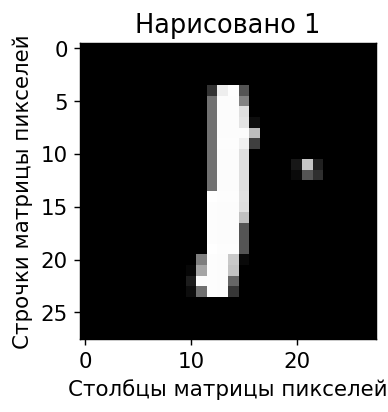

In [5]:
# Возьмем случайную строчку данных
number_of_row = random.randint(a=0, b=len(mnist_train))
print(f'Нам выпала {number_of_row} строчка')

# Достанем из 0 столбца метку картинки
label = mnist_train.iloc[number_of_row, 0]
print(f'Тут лежит цифра {label} нарисованная от руки')

# Достанем картинку из 784 пикселей и визуализируем ее как изображение 28х28
image = mnist_train.iloc[number_of_row, 1:].to_numpy()
image = image.reshape(28, 28)

# Визуализация матрицы картинки в градации серого
plt.figure(figsize=(3,3))
plt.imshow(image, cmap='gray')
plt.xlabel("Столбцы матрицы пикселей")
plt.ylabel("Строчки матрицы пикселей")
plt.title(f"Нарисовано {label}")
plt.show()

# **Код для датасета Pytorch**

## Класс MnistDataset

В классе набора данных PyTorch необходимо соблюсти определенные правила для его правильного использования другими удобными примитивами.

`Во-первых`: Нужно произвести наследование от класса **`torch.utils.data.Dataset`**. Тогда дальнейшее использование другими примитивами типа **`torch.utils.data.DataLoader`** будет корректным.

`Во-вторых` Необходимо переопределить два магических метода класса, а именно `__len__(self)` и `__getitem__(self, index)` которые перегружают соответственно функции `len()` и индексацию списка `object[index]`

In [6]:
class MnistDataset(Dataset):
    def __init__(self, images, labels):
        # Сюда будет попадать набор данных в csv (n, 784)
        self.images = torch.tensor(images, dtype=torch.float32)

        # Тут преобразуем mnist в пакет картинок
        self.images = self.images.reshape(-1, 1, 28, 28)

        # Сюда будет попадать 0 столбец набора данных с метками классов
        self.labels = torch.tensor(labels, dtype=torch.long)

    # Вызывается всегда, когда требуем len от объекта MnistDataset
    def __len__(self):
        # Возвращаем длину меток, сколько всего строк в датасете есть
        return len(self.labels)

    # Вызывается всегда, когда требуем элемент списка MnistDataset
    def __getitem__(self, idx):
        # Выдаем картинку с индексом idx и ее метку при вызове dataset[idx]
        return self.images[idx], self.labels[idx]

## Опробуем датасет картинок и его реализацию

Тип данных train_dataset <class '__main__.MnistDataset'>
Размерность картинок: torch.Size([20000, 1, 28, 28])
Размерность меток: torch.Size([20000])
Длина датасета: 20000
Метка случайного индекса 15232: tensor(3)
Картинка со случайным индексом 15232:


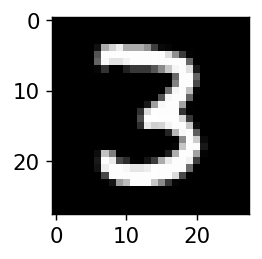

In [7]:
# Объявим тренировочный датасет
train_dataset = MnistDataset(
    images=mnist_train.iloc[:, 1:].to_numpy(),
    labels=mnist_train.iloc[:, 0].to_numpy()
)

# Объявим валидационный датасет
val_dataset = MnistDataset(
    images=mnist_test.iloc[:len(mnist_test)//2, 1:].to_numpy(),
    labels=mnist_test.iloc[:len(mnist_test)//2, 0].to_numpy()
)

# Объявим тестовый датасет
test_dataset = MnistDataset(
    images=mnist_test.iloc[len(mnist_test)//2:, 1:].to_numpy(),
    labels=mnist_test.iloc[len(mnist_test)//2:, 0].to_numpy()
)

# Случайный индекс
rnd_idx = random.randint(a=0, b=len(train_dataset))

# Тип данных train_dataset
print("Тип данных train_dataset", type(train_dataset))

# Поля объекта train_dataset
print("Размерность картинок:", train_dataset.images.shape)
print("Размерность меток:", train_dataset.labels.shape)

# Вызов len() от объекта Dataset
print("Длина датасета:", len(train_dataset))

# Выбор определенного элемента из набора данных выдает кортеж (image, label)
image, label = train_dataset[rnd_idx]
print(f"Метка случайного индекса {rnd_idx}:", label)
print(f"Картинка со случайным индексом {rnd_idx}:")

plt.figure(figsize=(2, 2))
plt.imshow(image[0], cmap='gray')
plt.show()

Такой класс датасета нужен, например, если мы не хотим доставать все картинки из оперативной памяти и под капотом хотим доставать картинки с жесткого диска. В объекте нужно сохранить пути к файлам изображений и меток а в `__getitem__` реализовать загрузку изображения в оперативную память сразу как тензора данных.

# **Сверточная сеть для классификации изображений**

Реализуем следующую архитектуру сверточной нейронной сети для классификации изображения по входной матрице пикселей

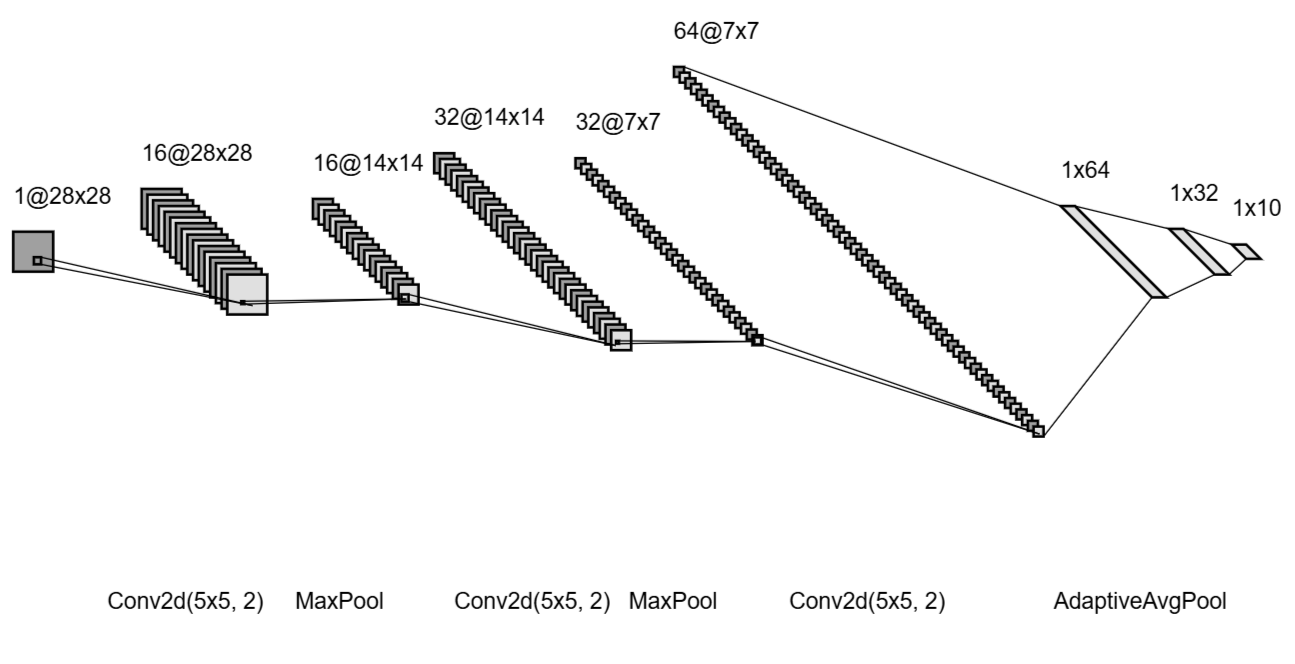

In [8]:
# Первый блок свертки
first_block = nn.Sequential(
    # На входе (n, 1, 28, 28)
    nn.Conv2d(
        in_channels=1,       # Канал серого
        out_channels=16,     # Выходных карт признаков
        kernel_size=(5, 5),  # Размер матрицы свертки
        padding=2            # Величина рамки из 0 вокруг входного изображения
        # Но лучше padding='same'
    ),
    # На выходе (n, 16, 28, 28)
    nn.ReLU()
)

# Второй блок свертки
second_block = nn.Sequential(
    # (n, 16, 14, 14) -> (n, 32, 14, 14)
    nn.Conv2d(16, 32, (5,5), padding='same'),
    nn.ReLU()
)

# Третий блок свертки
third_block = nn.Sequential(
    nn.Conv2d(32, 64, (5,5), padding='same'),
    nn.ReLU()
)

# Пулинг слой
maxpool = nn.MaxPool2d(
    kernel_size=(2, 2),  # размер окна в котором берем максимум
    stride=2             # шаг окна по изображению
)

# Полносвязная сеть в конце
fc_model = nn.Sequential(
    nn.Linear(64, 32),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(32, 10)
)

# Полноценная модель
model = nn.Sequential(
    # (n, 1, 28, 28) -> (n, 16, 28, 28)
    first_block,
    # (n, 16, 28, 28) -> (n, 16, 14, 14)
    maxpool,
    # На выходе (n, 16, 14, 14)
    # (n, 16, 14, 14) -> (n, 32, 14, 14)
    second_block,
    # (n, 32, 14, 14) -> (n, 32, 7, 7)
    maxpool,
    # (n, 32, 7, 7) -> (n, 64, 7, 7)
    third_block,
    # (n, 64, 7, 7) -> (n, 64, 1, 1)
    # Усреднить все пиксели во входном окне до изображения (1, 1)
    nn.AdaptiveAvgPool2d((1, 1)),
    # Превратить картинки в векторы (n, 64, 1, 1) -> (n, 64)
    nn.Flatten(),
    # Полносвязная сеть
    fc_model
)

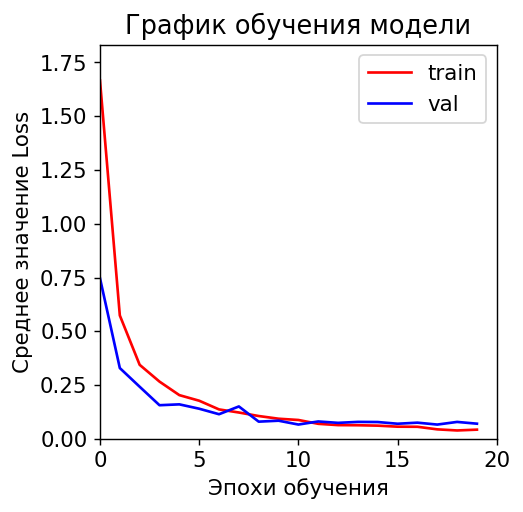

Среднее значение функции потерь на валидации 0.07036488357931375



Sequential(
  (0): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
  )
  (1): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=same)
    (1): ReLU()
  )
  (3): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=same)
    (1): ReLU()
  )
  (5): AdaptiveAvgPool2d(output_size=(1, 1))
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Sequential(
    (0): Linear(in_features=64, out_features=32, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=32, out_features=10, bias=True)
  )
)

In [9]:
best_score, best_model = train_eval_loop(
    model=model,                   # Обучение нашей модели
    train_dataset=train_dataset,   # На тренировочном наборе данных
    val_dataset=val_dataset,       # С проверкой на валидации
    criterion=nn.CrossEntropyLoss(), # С кросс-энтропийной функцией ошибки
    lr=1e-3,                       # Скорость обучения
    epoch_n=20,                    # Количество раз просмотра всех картинок моделью
    batch_size=200,                # Размер пачки картинок для шага обучения
    device=torch.device('cuda:0' if torch.cuda.is_available() else 'cpu'),
    early_stopping_patience=10,    # Если модель не улучшалась, прекращаем обучение
    l2_reg_alpha=0.1,              # Размер штрафа на большие веса по Ridge
    max_batches_per_epoch_train=200, # Сколько пачек картинок смотрим на одну эпоху
    max_batches_per_epoch_val=100,   # Сколько пачек картинок смотрим на шаге проверки
    optimizer_ctor=torch.optim.Adam, # Оптимизатор
    shuffle_train=True,             # Перемешать ли картинки в Train
    plot=True                       # Рисовать ли график обучения
)

# Переведем в безопасный режим
best_model.eval()

Вышли на плато и сохранили лучшую модель по средней метрике на валидационном наборе данных

In [10]:
# Предскажем вероятности и метки для каждого изображения из тестовой выборки
proba, labels = predict_with_model(
    model=best_model,
    dataset=test_dataset,
    device=torch.device('cuda:0' if torch.cuda.is_available() else 'cpu'),
    batch_size=100,
    num_workers=0,
    return_labels=True
)

100%|██████████| 50/50.0 [00:01<00:00, 30.81it/s]


              precision    recall  f1-score   support

           0       1.00      1.00      1.00       520
           1       1.00      1.00      1.00       564
           2       1.00      1.00      1.00       502
           3       1.00      1.00      1.00       510
           4       1.00      1.00      1.00       482
           5       1.00      1.00      1.00       436
           6       1.00      1.00      1.00       496
           7       1.00      1.00      1.00       516
           8       1.00      1.00      1.00       485
           9       1.00      1.00      1.00       489

    accuracy                           1.00      5000
   macro avg       1.00      1.00      1.00      5000
weighted avg       1.00      1.00      1.00      5000



<Figure size 1280x1280 with 0 Axes>

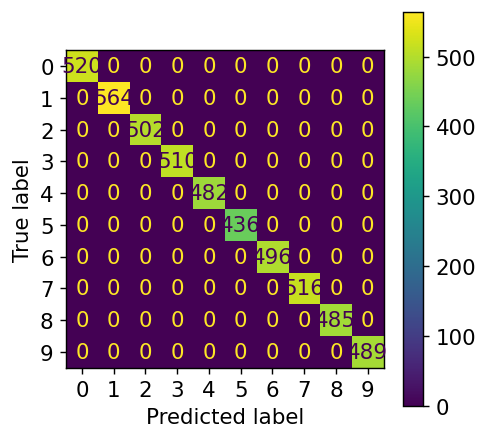

In [11]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

print(classification_report(test_dataset.labels, labels))
cm = confusion_matrix(test_dataset.labels, labels)

plt.figure(figsize=(10, 10))
ConfusionMatrixDisplay(cm).plot()
plt.show()

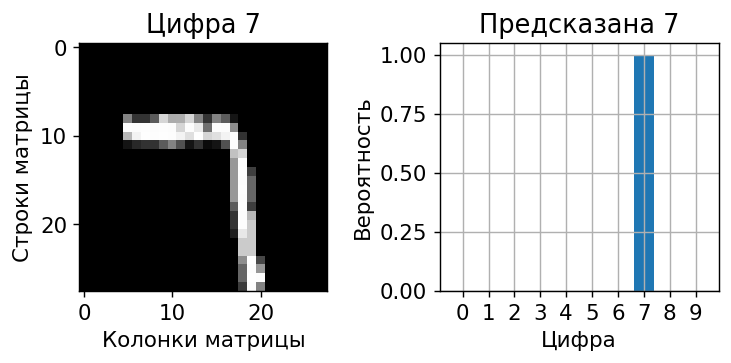

In [12]:
# Возьмем случайную картинку из теста
rnd_idx = random.randint(a=0, b=len(test_dataset))

image, label = test_dataset[rnd_idx]
preds = model(image.unsqueeze(0))
label_pred = torch.argmax(preds)

# Картинка-холст из двух графиков
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(6, 3))
# Визуализация картинки
ax[0].imshow(image[0], cmap='gray')
ax[0].set_xlabel("Колонки матрицы")
ax[0].set_ylabel("Строки матрицы")
ax[0].set_title(f"Цифра {label}")
# Визуализация вероятности принятия решения
ax[1].bar(range(10), torch.softmax(preds, axis=1).detach().numpy()[0])
ax[1].set_xticks(range(10), list(map(str, range(10))))
ax[1].set_xlabel('Цифра')
ax[1].set_ylabel('Вероятность')
ax[1].set_title(f'Предсказана {label_pred}')
ax[1].grid()
# Отображение холста
plt.tight_layout()
plt.show()

# **Выполнив две ячейки ниже, запустим холст для рисования цифры**

In [13]:
!pip install ipycanvas --quiet

from google.colab import output
output.enable_custom_widget_manager()

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.0/143.0 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 23.3 MB/s eta 0:00:00


In [16]:
from google.colab import output
from IPython.display import HTML, display
import numpy as np
from PIL import Image
import io, base64

# глобальная переменная, куда положим результат 28x28
latest_image_28x28 = None

def handle_drawing(data_url):
    """Колбэк, который получает base64-картинку из JS и
    сохраняет её как numpy-массив 28x28 в latest_image_28x28."""
    global latest_image_28x28

    # data_url: "data:image/png;base64,...."
    header, encoded = data_url.split(',', 1)
    img_bytes = base64.b64decode(encoded)

    # в PIL-изображение и в grayscale
    img = Image.open(io.BytesIO(img_bytes)).convert('L')

    # уменьшаем до 28x28
    img_28 = img.resize((28, 28), Image.LANCZOS)

    # в numpy и нормализация 0..1
    arr = np.array(img_28, dtype=np.float32)
    latest_image_28x28 = arr

    print("Изображение получено и сохранено в latest_image_28x28, shape:", arr.shape)

# регистрируем колбэк, чтобы JS мог его вызвать
output.register_callback('notebook.handle_drawing', handle_drawing)

html = """
<div id="digit-draw-wrapper" style="margin: 20px 0;">
  <canvas id="digit-canvas" width="280" height="280"
          style="border:2px solid black; touch-action:none; display:block;"></canvas>
  <button id="done-btn" style="margin-top:10px;">Готово</button>
  <button id="clear-btn" style="margin-top:10px; margin-left:10px;">Очистить</button>
</div>

<script>
  (function() {
    const canvas = document.getElementById('digit-canvas');
    const ctx = canvas.getContext('2d');

    // фон чёрный
    ctx.fillStyle = 'black';
    ctx.fillRect(0, 0, canvas.width, canvas.height);

    let drawing = false;

    function getPos(e) {
      const rect = canvas.getBoundingClientRect();
      const clientX = e.clientX || (e.touches && e.touches[0].clientX);
      const clientY = e.clientY || (e.touches && e.touches[0].clientY);
      return { x: clientX - rect.left, y: clientY - rect.top };
    }

    function startDraw(e) {
      e.preventDefault();
      drawing = true;
      const p = getPos(e);
      ctx.beginPath();
      ctx.moveTo(p.x, p.y);
    }

    function endDraw(e) {
      e.preventDefault();
      drawing = false;
      ctx.beginPath();
    }

    function draw(e) {
      if (!drawing) return;
      e.preventDefault();
      const p = getPos(e);

      ctx.lineWidth = 20;
      ctx.lineCap = 'round';
      ctx.strokeStyle = 'white';

      ctx.lineTo(p.x, p.y);
      ctx.stroke();
      ctx.beginPath();
      ctx.moveTo(p.x, p.y);
    }

    // мышь
    canvas.addEventListener('mousedown', startDraw);
    canvas.addEventListener('mouseup', endDraw);
    canvas.addEventListener('mouseout', endDraw);
    canvas.addEventListener('mousemove', draw);

    // тач
    canvas.addEventListener('touchstart', startDraw);
    canvas.addEventListener('touchend', endDraw);
    canvas.addEventListener('touchcancel', endDraw);
    canvas.addEventListener('touchmove', draw);

    // Кнопка "Очистить"
    document.getElementById('clear-btn').onclick = () => {
      ctx.fillStyle = 'black';
      ctx.fillRect(0, 0, canvas.width, canvas.height);
    };

    // Кнопка "Готово" — отправляем картинку в Python
    document.getElementById('done-btn').onclick = () => {
      const dataURL = canvas.toDataURL('image/png');
      google.colab.kernel.invokeFunction(
        'notebook.handle_drawing',
        [dataURL],
        {}
      );
    };
  })();
</script>
"""

display(HTML(html))

Изображение получено и сохранено в latest_image_28x28, shape: (28, 28)


# Протестируем модель на прогнозирование цифры

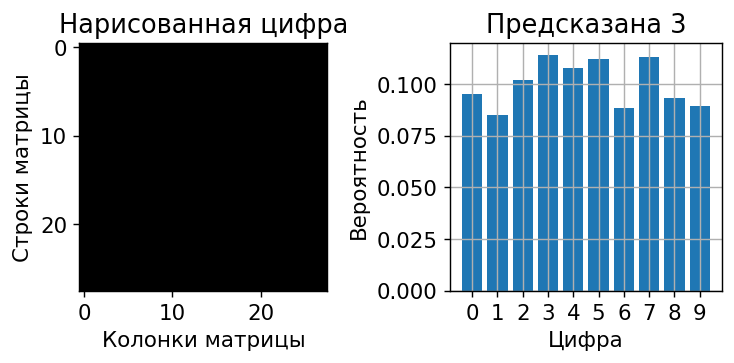

In [17]:
probas = best_model(torch.tensor(latest_image_28x28, dtype=torch.float32).reshape(1, 1, 28, 28))
label = torch.argmax(probas, axis=1)[0]
probas = torch.softmax(probas, axis=1)

# Картинка-холст из двух графиков
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(6, 3))

# Визуализация картинки
ax[0].imshow(latest_image_28x28, cmap='gray')
ax[0].set_xlabel("Колонки матрицы")
ax[0].set_ylabel("Строки матрицы")
ax[0].set_title(f"Нарисованная цифра")

# Визуализация вероятности принятия решения
ax[1].bar(range(10), probas.detach().numpy()[0])
ax[1].set_xticks(range(10), list(map(str, range(10))))
ax[1].set_xlabel('Цифра')
ax[1].set_ylabel('Вероятность')
ax[1].set_title(f'Предсказана {int(label)}')
ax[1].grid()
# Отображение холста
plt.tight_layout()
plt.show()

# **Сохраним модель на диск для дальнейшего использования где либо**

In [18]:
torch.save(best_model, 'mnist_model.pth')

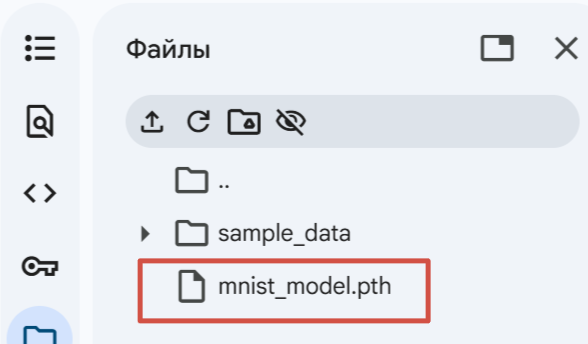

In [19]:
# Загрузить модель в новом коде
import torch

loaded_model = torch.load(
    f='/content/mnist_model.pth',
    weights_only=False
)

loaded_model

Sequential(
  (0): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
  )
  (1): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=same)
    (1): ReLU()
  )
  (3): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=same)
    (1): ReLU()
  )
  (5): AdaptiveAvgPool2d(output_size=(1, 1))
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Sequential(
    (0): Linear(in_features=64, out_features=32, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=32, out_features=10, bias=True)
  )
)